In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 62445319.68it/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


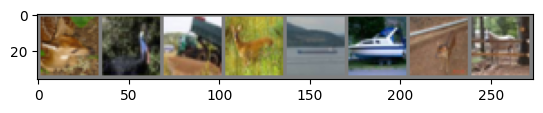

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [4]:
import torch
import torch.nn as nn
from torchsummary import summary

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=7)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(8*8*256, 128)
        self.dense2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x

model = CustomModel()
model = model.to(device)

# Print model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           4,736
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 20, 20]         100,416
              ReLU-4           [-1, 64, 20, 20]               0
            Conv2d-5          [-1, 128, 14, 14]         401,536
              ReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 8, 8]       1,605,888
              ReLU-8            [-1, 256, 8, 8]               0
           Flatten-9                [-1, 16384]               0
           Linear-10                  [-1, 128]       2,097,280
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 4,211,146
Trainable params: 4,211,146
Non-trainable params: 0
---------------------------

#### Loss, Optimizer, and Evaluation Function

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

#### Train

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 250

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/250], Loss: 2.0730, Accuracy: 23.27%, Test Loss: 1.8608, Test Accuracy: 32.07%
Epoch [2/250], Loss: 1.8211, Accuracy: 33.49%, Test Loss: 1.7637, Test Accuracy: 34.51%
Epoch [3/250], Loss: 1.7363, Accuracy: 36.29%, Test Loss: 1.6943, Test Accuracy: 37.90%
Epoch [4/250], Loss: 1.6848, Accuracy: 37.99%, Test Loss: 1.6776, Test Accuracy: 38.35%
Epoch [5/250], Loss: 1.6359, Accuracy: 40.08%, Test Loss: 1.6049, Test Accuracy: 41.70%
Epoch [6/250], Loss: 1.5912, Accuracy: 41.76%, Test Loss: 1.5687, Test Accuracy: 42.30%
Epoch [7/250], Loss: 1.5521, Accuracy: 43.23%, Test Loss: 1.5425, Test Accuracy: 43.29%
Epoch [8/250], Loss: 1.5268, Accuracy: 44.44%, Test Loss: 1.5328, Test Accuracy: 43.43%
Epoch [9/250], Loss: 1.4971, Accuracy: 45.53%, Test Loss: 1.4780, Test Accuracy: 46.10%
Epoch [10/250], Loss: 1.4768, Accuracy: 46.34%, Test Loss: 1.4553, Test Accuracy: 47.03%
Epoch [11/250], Loss: 1.4498, Accuracy: 47.31%, Test Loss: 1.4321, Test Accuracy: 47.92%
Epoch [12/250], Loss: 1.4312, 

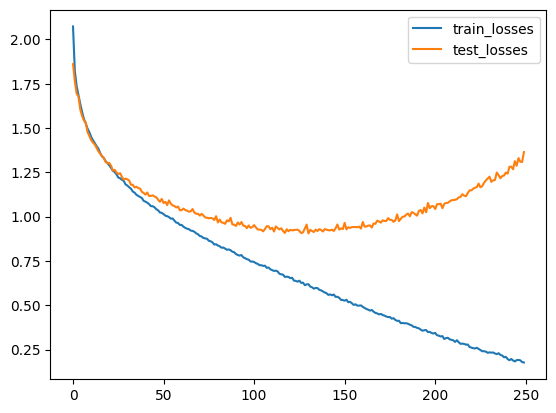

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

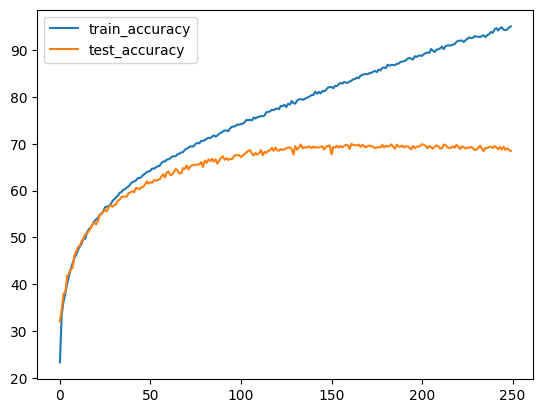

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

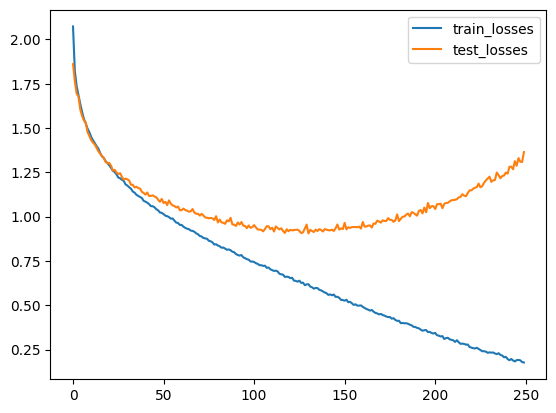

In [11]:
import matplotlib.pyplot as plt
# %matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

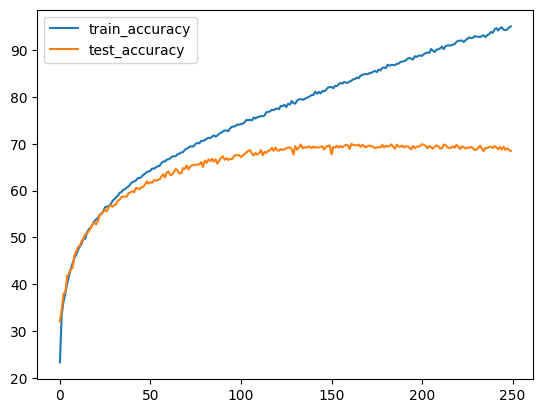

In [12]:
import matplotlib.pyplot as plt
# %matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()